## Проект по детекции эмоций по аудио

In [6]:
import pandas as pd
import numpy as np
import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio, display

import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint

import joblib

import soundfile as sf

#### Загрузка датасета и проверка классов

In [93]:
data_path = 'C:\projects\Python\ml\DAILY_WORK\project_audio\dataset'

In [3]:
for files in os.listdir(data_path):
    print(files)

OAF_angry
OAF_disgust
OAF_Fear
OAF_happy
OAF_neutral
OAF_Pleasant_surprise
OAF_Sad
YAF_angry
YAF_disgust
YAF_fear
YAF_happy
YAF_neutral
YAF_pleasant_surprised
YAF_sad


#### Распределение количества данных внутри каждого класса

In [4]:
data_amount_info = {}
data_duration_info = {}

for emotion in os.listdir(data_path):
    print(emotion)
    emotion_path = os.path.join(data_path, files)
    for file in os.listdir(emotion_path):
        file_path = os.path.join(emotion_path, file)
        if file.endswith(".wav"):
            duration = librosa.get_duration(path=file_path)  # продолжительность файла
            data_duration_info[emotion] = data_duration_info.get(emotion, 0) + duration  # добавляем продолжительность к нужной эмоции

            data_amount_info[emotion] = data_amount_info.get(emotion, 0) + 1  # считаем количество файлов
        else:
            print('Найден файл с некорректным разрешением')

OAF_angry
OAF_disgust
OAF_Fear
OAF_happy
OAF_neutral
OAF_Pleasant_surprise
OAF_Sad
YAF_angry
YAF_disgust
YAF_fear
YAF_happy
YAF_neutral
YAF_pleasant_surprised
YAF_sad


Заметим, что среди классов есть повторяющиеся. Дальше узнаем в чем разница

In [5]:
# средняя продолжительность звукового фрагмента данных
for emotion in data_duration_info.keys():
    data_duration_info[emotion] /= data_amount_info[emotion]

In [6]:
data_amount_info

{'OAF_angry': 168,
 'OAF_disgust': 168,
 'OAF_Fear': 168,
 'OAF_happy': 168,
 'OAF_neutral': 168,
 'OAF_Pleasant_surprise': 168,
 'OAF_Sad': 168,
 'YAF_angry': 168,
 'YAF_disgust': 168,
 'YAF_fear': 168,
 'YAF_happy': 168,
 'YAF_neutral': 168,
 'YAF_pleasant_surprised': 168,
 'YAF_sad': 168}

In [7]:
data_duration_info

{'OAF_angry': 2.2740452882226037,
 'OAF_disgust': 2.2740452882226037,
 'OAF_Fear': 2.2740452882226037,
 'OAF_happy': 2.2740452882226037,
 'OAF_neutral': 2.2740452882226037,
 'OAF_Pleasant_surprise': 2.2740452882226037,
 'OAF_Sad': 2.2740452882226037,
 'YAF_angry': 2.2740452882226037,
 'YAF_disgust': 2.2740452882226037,
 'YAF_fear': 2.2740452882226037,
 'YAF_happy': 2.2740452882226037,
 'YAF_neutral': 2.2740452882226037,
 'YAF_pleasant_surprised': 2.2740452882226037,
 'YAF_sad': 2.2740452882226037}

В датасете одинаковое количество данных на каждую эмоцию и одинаковая средняя длина записи

#### Демонстрация случайных записей

In [8]:
for emotion in os.listdir(data_path):
    emotion_path = os.path.join(data_path, emotion)
    file = fr'{emotion_path}\{np.random.choice(os.listdir(emotion_path))}'
    file_path = os.path.join(emotion_path, file)
    print(emotion)
    display(Audio(file_path))

OAF_angry


OAF_disgust


OAF_Fear


OAF_happy


OAF_neutral


OAF_Pleasant_surprise


OAF_Sad


YAF_angry


YAF_disgust


YAF_fear


YAF_happy


YAF_neutral


YAF_pleasant_surprised


YAF_sad


Проанализировав записи, становится понятно, что разница между одинаковыми классами в том, что их произносят разные люди. Соответственно, их можно поместить в один класс в будущем

#### Построение спектрограмм и waveplot до обработки

In [9]:
def create_waveplot(data, sr, e, ax=None):
    if ax is not None:
        plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    return librosa.display.waveshow(data, sr=sr, ax=ax, color='#5EE8AC')

def create_spectrogram(data, sr, e, ax=None, **kwargs):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    if ax is not None:
        plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    return librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', ax=ax, cmap='Accent', **kwargs)

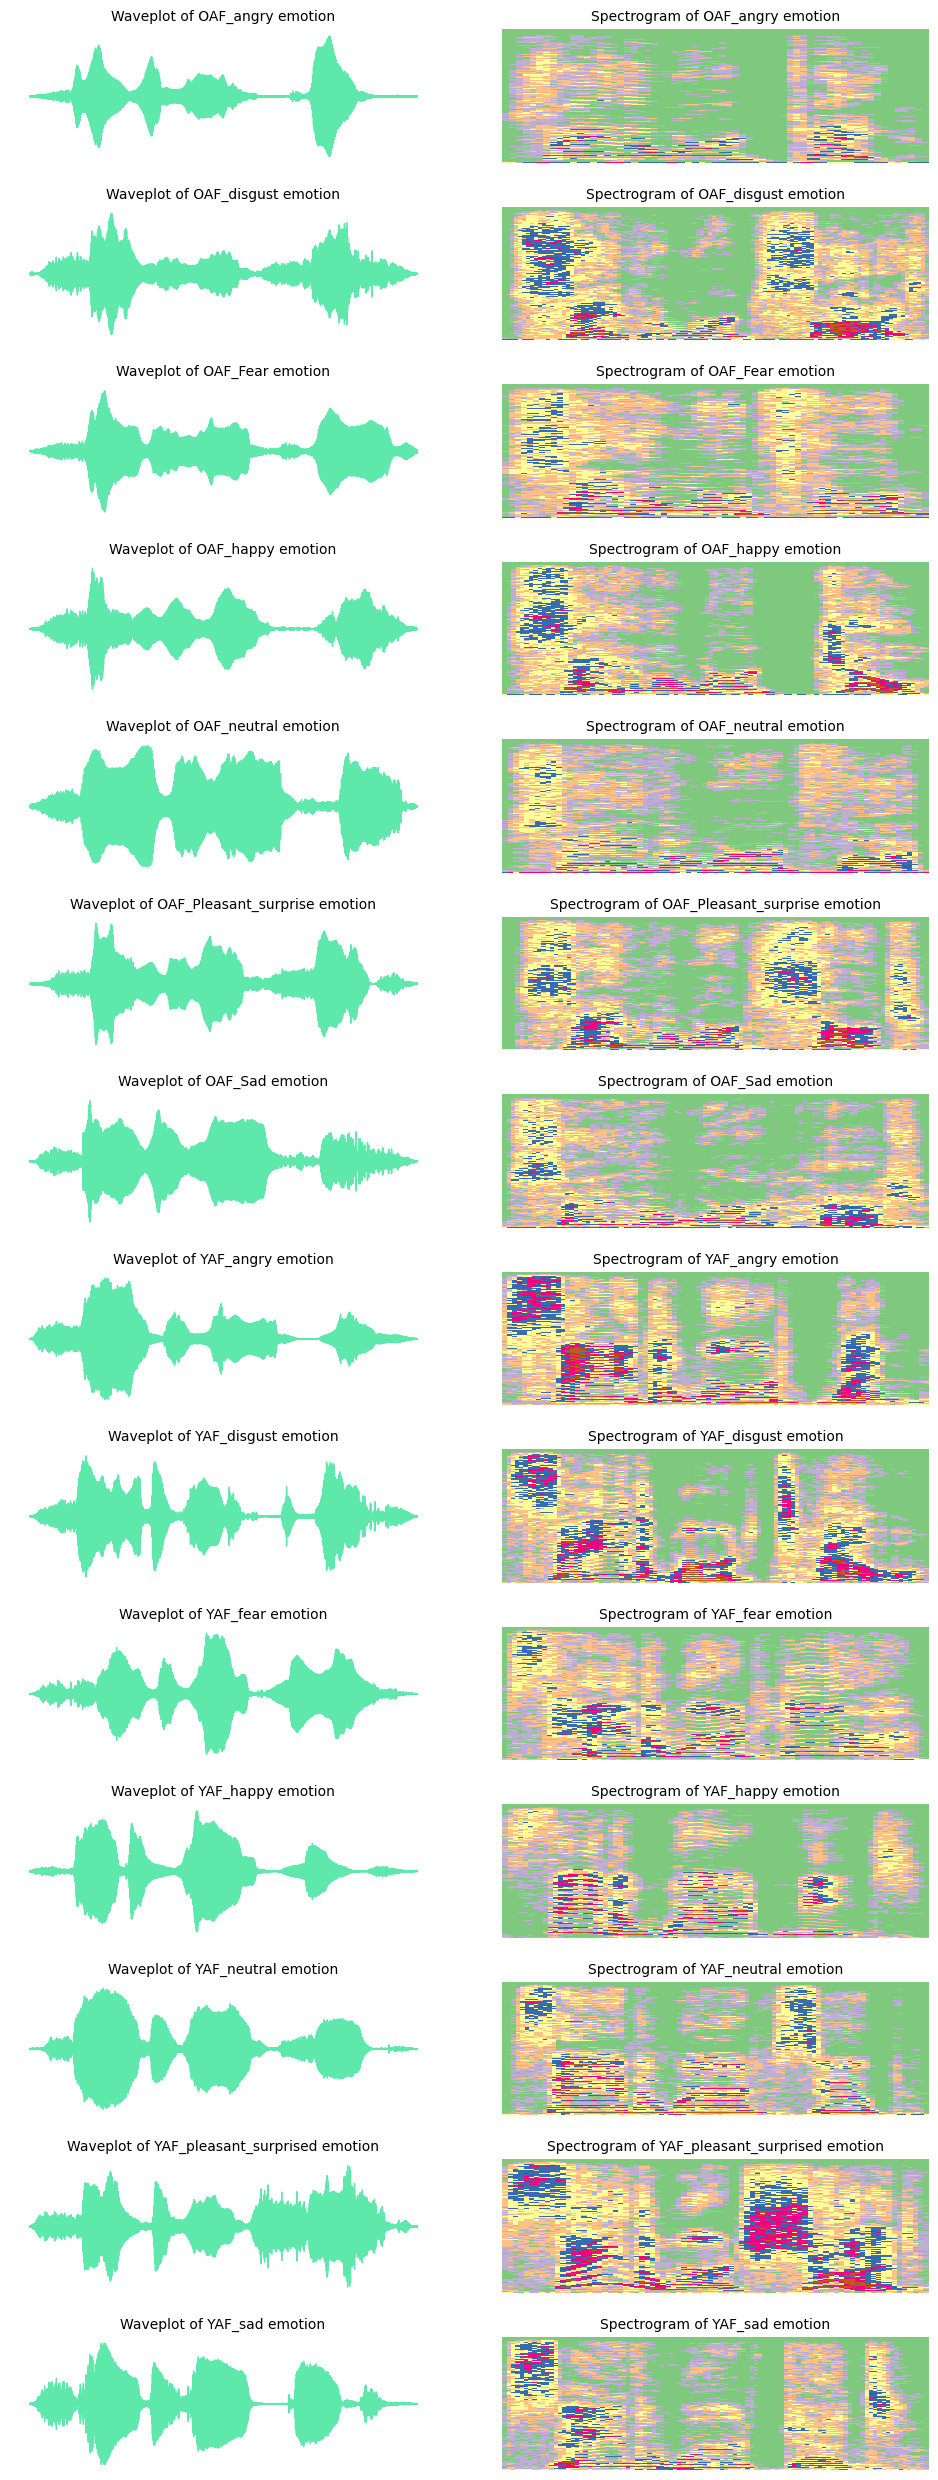

In [10]:
fig, axes = plt.subplots(len(data_amount_info), 2)
fig.set_size_inches(10, 25)
fig.tight_layout()

for emotion, ax in zip(os.listdir(data_path), axes):
    emotion_path = os.path.join(data_path, emotion)
    file = fr'{emotion_path}\{np.random.choice(os.listdir(emotion_path))}'  # берем случайный файл из датасета по каждой эмоции
    file_path = os.path.join(emotion_path, file)
    data, sr = librosa.load(file_path)
    create_waveplot(data, sr, emotion, ax=ax[0])
    create_spectrogram(data, sr, emotion, ax=ax[1])
    ax[0].set_title(f'Waveplot of {emotion} emotion', size=10)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[1].set_title(f'Spectrogram of {emotion} emotion', size=10)

#### Объединение классов

Перенос и объединение классов, без изменения и переноса изначального датасета

In [223]:
def create_dataset(path_from, path_to):
    for emotion in os.listdir(path_from):
        k = -1
        emotion_name = emotion[4:] if emotion != 'YAF_pleasant_surprised' else 'pleasant_surprise'
        print(emotion)
        final_path = f'{path_to}/{emotion_name.lower()}'
        if not os.path.exists(final_path):
            os.mkdir(final_path)
        emotion_path = os.path.join(data_path, emotion)
        for file in os.listdir(emotion_path):
            k += 1

            file_path_from = os.path.join(emotion_path, file)
            file_path_to = os.path.join(final_path, f'{emotion_name}_{k}.wav')
            audio_data, sampling_rate = librosa.load(file_path_from)
            sf.write(file_path_to, audio_data, sampling_rate)

In [225]:
create_dataset(data_path, "C:\projects\Python\ml\DAILY_WORK\project_audio\prepared_dataset")

OAF_angry
OAF_disgust
OAF_Fear
OAF_happy
OAF_neutral
OAF_Pleasant_surprise
OAF_Sad
YAF_angry
YAF_disgust
YAF_fear
YAF_happy
YAF_neutral
YAF_pleasant_surprised
YAF_sad


In [226]:
data_path_prep = "C:\projects\Python\ml\DAILY_WORK\project_audio\prepared_dataset"

Узнаем частоту записей, чтобы приводить все к ней при дальнейшем использовании

In [227]:
emotion = np.random.choice(os.listdir(data_path_prep))
file = np.random.choice(os.listdir(os.path.join(data_path_prep, emotion)))
path = fr'{data_path_prep}\{emotion}\{file}'

In [99]:
data, sr = librosa.load(path)

In [100]:
sr  # sampling rate

22050

### `Обучим 2 варианта нейросети`
- предобработка данных через MFCC
- предобработка данных через STFT

`1. Что это такое?`

##### **MFCC (Mel Frequency Cepstral Coefficients)**:
- **Расшифровка**: Коэффициенты кепстра мел-шкалы частот.
- **MFCC** - это способ представления звука, который приближен к тому, как его слышит человек. Этот метод используется, чтобы выделить важные частоты для машинного анализа речи. MFCC преобразует звуковые данные таким образом, что низкие частоты, на которые мы более чувствительны, получают больше внимания.

##### **STFT (Short-Time Fourier Transform)**:
- **Расшифровка**: Коротковременное преобразование Фурье.
- **STFT** - это метод, который разбивает длинный звуковой сигнал на маленькие отрезки (окна) и анализирует частоты в каждом из них. Он помогает отслеживать, как частоты меняются во времени.

#### MFCC

#### Подготовка к обучению

In [228]:
def feature_extractor(file_name):
    audio_data, sampling_rate = librosa.load(file_name)
    mfcc_features = librosa.feature.mfcc(y=audio_data, sr=sampling_rate, n_mfcc=40)
    scaled_mfcc_features = np.mean(mfcc_features.T, axis=0)
    return scaled_mfcc_features

In [229]:
extracted_features = []

for emotion in os.listdir(data_path_prep):
    emotion_path = os.path.join(data_path_prep, emotion)
    for file in os.listdir(emotion_path):
        file_path = os.path.join(emotion_path, file)
        data = feature_extractor(file_path)
        extracted_features.append([data, emotion])

In [230]:
data = pd.DataFrame(extracted_features, columns=['data', 'label'])

In [231]:
data.sample(5)

,data,label
442,"[-342.28094, 37.329742, -10.417388, 19.032045,...",fear
1135,"[-343.3134, 20.743715, -25.075123, -13.123713,...",pleasant_surprise
969,"[-382.411, 28.184484, 6.454998, 31.450792, 0.5...",neutral
1085,"[-342.6313, 46.030643, -17.510345, 0.18553269,...",pleasant_surprise
891,"[-366.65594, 74.364265, -0.3221919, 25.092157,...",neutral


In [234]:
data.shape

(1400, 2)

In [235]:
num_labels = data.label.nunique()
num_labels

7

In [236]:
X = np.array(data['data'].to_list())
y = np.array(data['label'].to_list())

In [237]:
X.shape

(1400, 40)

In [238]:
from sklearn.preprocessing import OneHotEncoder

In [242]:
le = OneHotEncoder(sparse_output=False)
y = le.fit_transform(y.reshape(-1, 1))
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [243]:
y.shape, X.shape

((1400, 7), (1400, 40))

In [244]:
import joblib
joblib.dump(le, 'OHE_mfcc.joblib')

['OHE_mfcc.joblib']

In [245]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [246]:
x_val, y_val = x_test[:len(x_test)//2], y_test[:len(y_test)//2]
x_test, y_test = x_test[len(x_test)//2:], y_test[len(y_test)//2:]

In [275]:
model_mfcc = Sequential()

model_mfcc.add(layers.Input(shape=(40,)))

# первый слой
model_mfcc.add(layers.Dense(100))
model_mfcc.add(layers.Activation('relu'))
model_mfcc.add(layers.Dropout(0.5))

# второй слой
model_mfcc.add(layers.Dense(200))
model_mfcc.add(layers.Activation('relu'))
model_mfcc.add(layers.Dropout(0.5))

# третий слой
model_mfcc.add(layers.Dense(200))
model_mfcc.add(layers.Activation('relu'))
model_mfcc.add(layers.Dropout(0.5))

# финальный слой
model_mfcc.add(layers.Dense(num_labels))
model_mfcc.add(layers.Activation('softmax'))

In [276]:
model_mfcc.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 100)               4100      
                                                                 
 activation_39 (Activation)  (None, 100)               0         
                                                                 
 dropout_32 (Dropout)        (None, 100)               0         
                                                                 
 dense_43 (Dense)            (None, 200)               20200     
                                                                 
 activation_40 (Activation)  (None, 200)               0         
                                                                 
 dropout_33 (Dropout)        (None, 200)               0         
                                                                 
 dense_44 (Dense)            (None, 200)             

In [280]:
model_mfcc.compile(optimizer='adam',
              loss='categorical_crossentropy',  # используется если классы пересекаются между собой
              metrics=['accuracy']
              )

In [281]:
epochs = 200
batch_size = 16

callbacks = keras.callbacks.EarlyStopping(monitor='loss', patience=8, min_delta=0.01, verbose=0)

In [282]:
history_mfcc = model_mfcc.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
70/70 [==============================] - 0s 2ms/step - loss: 25.5514 - accuracy: 0.1500 - val_loss: 2.0931 - val_accuracy: 0.1143
Epoch 2/200
70/70 [==============================] - 0s 1ms/step - loss: 8.1415 - accuracy: 0.1893 - val_loss: 1.7397 - val_accuracy: 0.2857
Epoch 3/200
70/70 [==============================] - 0s 1ms/step - loss: 4.3269 - accuracy: 0.2223 - val_loss: 1.5648 - val_accuracy: 0.5214
Epoch 4/200
70/70 [==============================] - 0s 1ms/step - loss: 2.8288 - accuracy: 0.2777 - val_loss: 1.4232 - val_accuracy: 0.7357
Epoch 5/200
70/70 [==============================] - 0s 1ms/step - loss: 2.0644 - accuracy: 0.3420 - val_loss: 1.0777 - val_accuracy: 0.8357
Epoch 6/200
70/70 [==============================] - 0s 1ms/step - loss: 1.5007 - accuracy: 0.4679 - val_loss: 0.9024 - val_accuracy: 0.9071
Epoch 7/200
70/70 [==============================] - 0s 1ms/step - loss: 1.1870 - accuracy: 0.5911 - val_loss: 0.6818 - val_accuracy: 0.9429
Epoch 8/200


In [283]:
model_mfcc.save('model_mfcc.keras')

#### STFT

#### Подготовка к обучению

In [284]:
def get_spectrogram(waveform): 
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128) 
    spectrogram = tf.abs(spectrogram)
    return spectrogram[..., tf.newaxis]

In [285]:
def get_spectrogram_dataset(dataset):
    dataset = dataset.map(lambda x, y: (get_spectrogram(x), y),
                          num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

In [286]:
def squeeze(audio, labels):
    '''перевод звука в формат mono'''
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

In [287]:
training_set, validation_set = keras.utils.audio_dataset_from_directory(
    directory=data_path_prep,
    batch_size=16,
    validation_split=0.2,
    output_sequence_length=22_050,
    subset='both',
    seed=42
)

Found 1400 files belonging to 7 classes.
Using 1120 files for training.
Using 280 files for validation.


In [288]:
label_names = training_set.class_names
label_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'pleasant_surprise', 'sad']

In [289]:
training_set = training_set.map(squeeze, tf.data.AUTOTUNE)
validation_set = validation_set.map(squeeze, tf.data.AUTOTUNE)

In [290]:
train_set = get_spectrogram_dataset(training_set) 
validation_set = get_spectrogram_dataset(validation_set) 
  
# разбиваем на валидационный и тестовый
val_set = validation_set.take(validation_set.cardinality() // 2) 
test_set = validation_set.skip(validation_set.cardinality() // 2)

In [291]:
input_shape = next(iter(train_set))[0][0].shape 
print("Input shape:", input_shape) 
num_labels = len(label_names)

Input shape: (171, 129, 1)


In [292]:
# все размеры должны совпадать

train_set_shape = train_set.element_spec[0].shape 
val_set_shape = val_set.element_spec[0].shape 
test_set_shape = test_set.element_spec[0].shape 
  
print("Train set shape:", train_set_shape) 
print("Validation set shape:", val_set_shape) 
print("Testing set shape:", test_set_shape)

Train set shape: (None, 171, 129, 1)
Validation set shape: (None, 171, 129, 1)
Testing set shape: (None, 171, 129, 1)


In [293]:
model_stft = tf.keras.Sequential([ 
        tf.keras.layers.Input(shape=input_shape), 

        tf.keras.layers.Resizing(64, 64), 
        tf.keras.layers.Normalization(), 
          
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(), 
        tf.keras.layers.Dropout(0.5), 
        tf.keras.layers.Flatten(),
          
        tf.keras.layers.Dense(num_labels, activation='softmax')
])

In [294]:
model_stft.compile( 
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy'] 
)

In [295]:
model_stft.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 64, 64, 1)         0         
                                                                 
 normalization_3 (Normaliza  (None, 64, 64, 1)         3         
 tion)                                                           
                                                                 
 conv2d_3 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                            
                                                                 
 dropout_35 (Dropout)        (None, 31, 31, 64)        0         
                                                                 
 flatten_3 (Flatten)         (None, 61504)           

In [296]:
epochs = 10
verbose = True

monitor = 'val_loss'
min_delta = 0.01
patience = 3

callbacks = [keras.callbacks.EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience, verbose=verbose)]

In [297]:
history_stft = model_stft.fit(
    train_set,
    validation_data=val_set,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/10
70/70 [==============================] - 2s 21ms/step - loss: 0.4082 - accuracy: 0.8821 - val_loss: 0.0839 - val_accuracy: 0.9861
Epoch 2/10
70/70 [==============================] - 2s 21ms/step - loss: 0.0417 - accuracy: 0.9920 - val_loss: 0.0182 - val_accuracy: 0.9931
Epoch 3/10
70/70 [==============================] - 2s 21ms/step - loss: 0.0133 - accuracy: 0.9991 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 4/10
70/70 [==============================] - 2s 21ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.0101 - val_accuracy: 1.0000
Epoch 5/10
70/70 [==============================] - 2s 21ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 6/10
70/70 [==============================] - 2s 21ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 6: early stopping


In [298]:
model_stft.save('model_stft.keras')

In [61]:
# model = tf.keras.models.load_model('model.keras')

### Оценка обучения

In [299]:
model_stft = tf.keras.models.load_model('model_stft.keras')
model_mfcc = tf.keras.models.load_model('model_mfcc.keras')

In [300]:
model_mfcc.evaluate(x_test, y_test)

5/5 [==============================] - 0s 1ms/step - loss: 0.0072 - accuracy: 1.0000


[0.0072163608856499195, 1.0]

In [301]:
model_stft.evaluate(test_set)

9/9 [==============================] - 0s 5ms/step - loss: 0.0058 - accuracy: 1.0000


[0.005782071501016617, 1.0]

In [302]:
def full_plot_model_metrics(history):
    # разделяем данные из истории обучения на треноровочные и тестовые
    metrics = list(history.history.items())[:len(history.history.items())//2+1]
    val_metrics = list(history.history.items())[len(history.history.items())//2:]

    plt.figure(figsize=(30, 5))

    for i, metric, val_metric in zip(range(len(history.history.keys())), metrics, val_metrics):
        plt.subplot(1, len(history.history.items()), i+1)
        plt.plot(range(1, len(metric[1])+1), metric[1], c='blue', label='training')
        plt.plot(range(1, len(val_metric[1])+1), val_metric[1], c='red', label='validation')
        plt.legend(loc='upper right')
        plt.title(metric[0].upper())
        plt.xlabel('epochs')
        plt.ylabel(metric[0])
        plt.tight_layout(h_pad=2, w_pad=2)
        plt.grid(True)

Для модели с обработкой MFCC

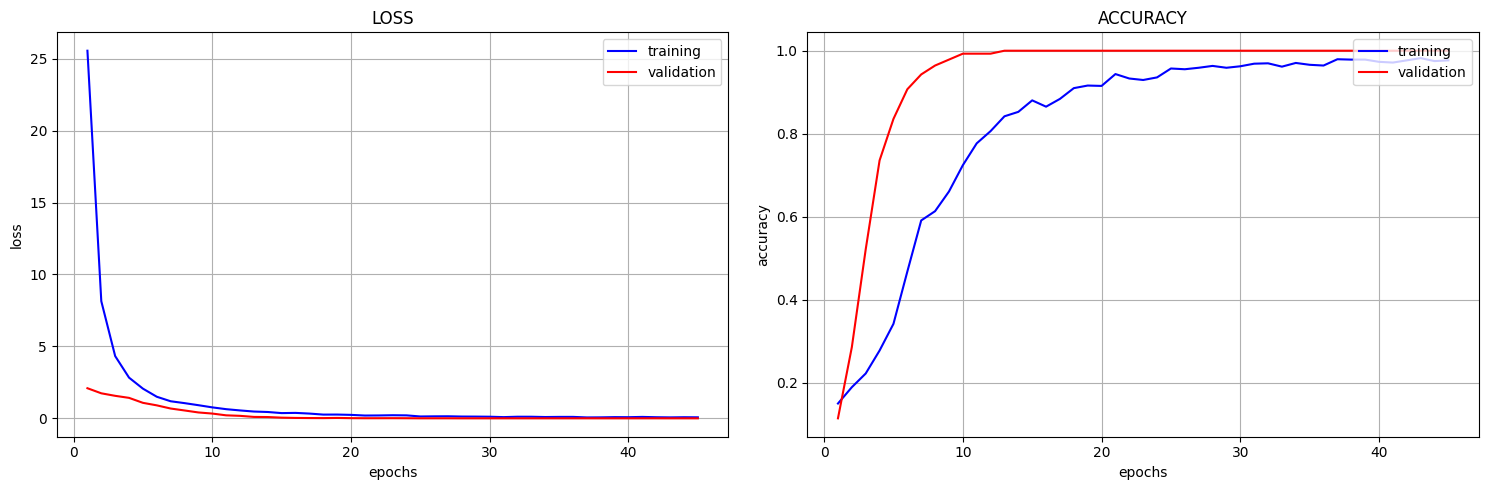

In [303]:
full_plot_model_metrics(history_mfcc)

Для модели с обработкой STFT

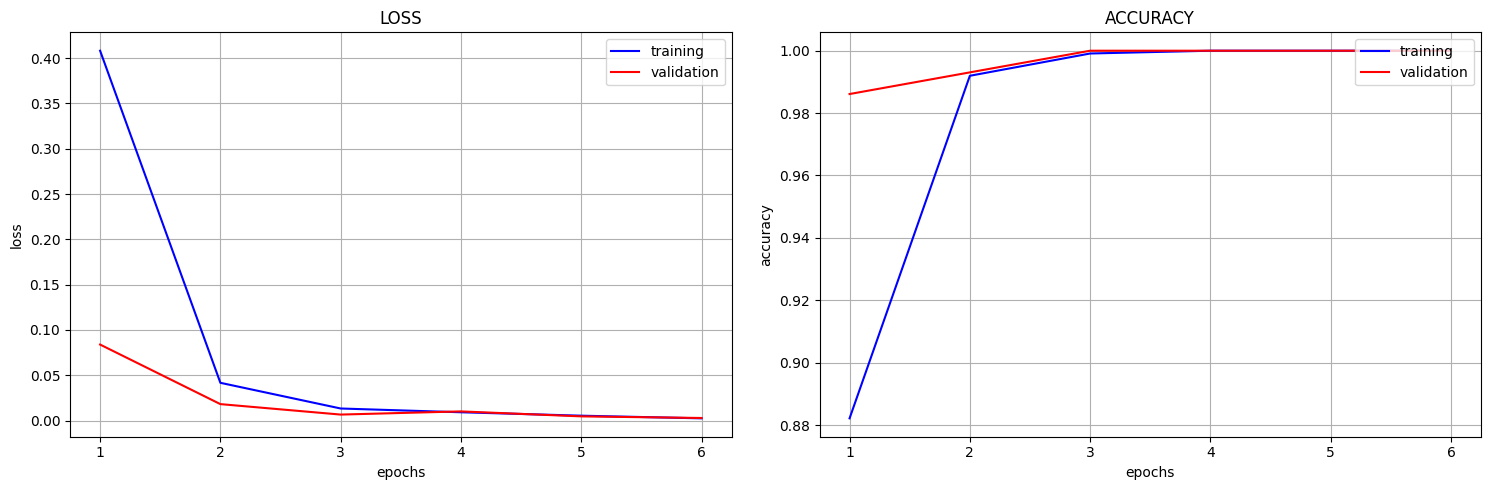

In [304]:
full_plot_model_metrics(history_stft)

Матрица путаницы

In [305]:
def prepare_predictions(pred):
    positions =  np.argmax(pred, axis=1)
    emotions =  np.array(label_names)[positions].reshape(-1, 1)
    return emotions

In [316]:
y_pred_mfcc = prepare_predictions(model_mfcc.predict(x_test))
y_pred_stft = prepare_predictions(model_stft.predict(test_set))
y_test_mfcc = prepare_predictions(y_test)

9/9 [==============================] - 0s 6ms/step


In [317]:
y_true = np.concatenate([y for x, y in test_set])
y_true = np.array(label_names)[y_true].reshape(-1, 1)

In [318]:
from sklearn.metrics import ConfusionMatrixDisplay

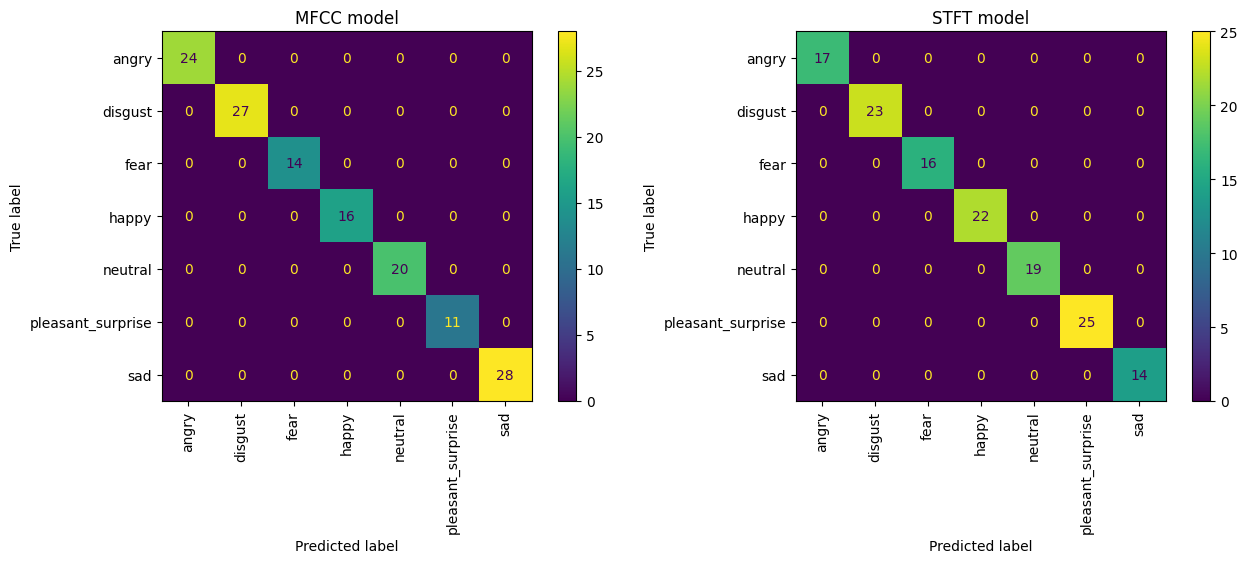

In [319]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
ax1.set_title('MFCC model')
ax2.set_title('STFT model')

ConfusionMatrixDisplay.from_predictions(y_test_mfcc, y_pred_mfcc, xticks_rotation=90, ax=ax1)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred_stft, xticks_rotation=90, ax=ax2)

Метрики после обучения

In [324]:
print(classification_report(y_test_mfcc, y_pred_mfcc))

                   precision    recall  f1-score   support

            angry       1.00      1.00      1.00        24
          disgust       1.00      1.00      1.00        27
             fear       1.00      1.00      1.00        14
            happy       1.00      1.00      1.00        16
          neutral       1.00      1.00      1.00        20
pleasant_surprise       1.00      1.00      1.00        11
              sad       1.00      1.00      1.00        28

         accuracy                           1.00       140
        macro avg       1.00      1.00      1.00       140
     weighted avg       1.00      1.00      1.00       140



In [325]:
print(classification_report(y_true, y_pred_stft))

                   precision    recall  f1-score   support

            angry       1.00      1.00      1.00        17
          disgust       1.00      1.00      1.00        23
             fear       1.00      1.00      1.00        16
            happy       1.00      1.00      1.00        22
          neutral       1.00      1.00      1.00        19
pleasant_surprise       1.00      1.00      1.00        25
              sad       1.00      1.00      1.00        14

         accuracy                           1.00       136
        macro avg       1.00      1.00      1.00       136
     weighted avg       1.00      1.00      1.00       136



### Вывод

Исходя из графика обучения моделей и их матриц путаницы при тесте, можно сделать вывод, что модель, обученная на STFT преобразованных данных показала себя незначительно, но лучше.
Это подтверждает слова о том, что STFT лучше работает с шумными записями. Приведенный датасет не был сильно шумным, однако разница все равно есть. В дальшем при использовании однозначно могут быть шумы. Это стоит учитывать

Выбираю модель `model_stft`

### Тестирование

In [68]:
path = fr"C:\projects\Python\ml\DAILY_WORK\project_audio\test_files\test_4.wav"

In [74]:
data, sr = librosa.load(path)

In [75]:
sr

22050

In [78]:
data, samplerate = sf.read(path)
sf.write(f'{path[:-4]}_new.wav', data, samplerate, subtype='PCM_16')

In [80]:
Input = tf.io.read_file(f'{path[:-4]}_new.wav') 
x, sample_rate = tf.audio.decode_wav(Input, desired_channels=1, desired_samples=22_050)
audio, labels = squeeze(x, 'yes')

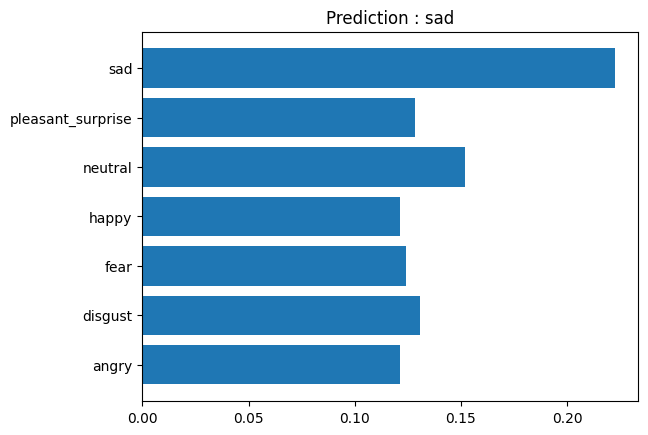

In [81]:
x = get_spectrogram(audio) 
x = tf.expand_dims(x, axis=0) 
  
prediction = model(x) 
plt.barh(label_names, tf.nn.softmax(prediction[0])) 
plt.title('Prediction : '+label_names[np.argmax(prediction, axis=1).item()]) 
plt.show()

In [82]:
test_path = fr'C:\projects\Python\ml\DAILY_WORK\project_audio\test_files'

In [83]:
waveform = audio 
display(Audio(waveform, rate=22_050))

In [84]:
Audio(path)